In [31]:
from classes.connectivity_blocks import *
from classes.network_dynamics import *
from classes.task import *
import pandas
import scipy.io as sio
import pickle

import matplotlib as mpl
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)

In [32]:
def model_parameters():
    modelparams = dict(
            seed = 4,
            #network parameters
            n_ctx = 89,
            N_block = 400, #neurons per region
            N_recorded = 150, #neurons recorded per region

            #transfer function Pereira&Brunel,18
            rm = 1,#76.2,
            beta = 1, #Pereira&Brunel
            h0 = .1,
            amp_offset = 1,

            #dynamics excitatory
            tau_ctx =  60 * 1e-3,#s mainly NMDA

            #private noise 
            sigma_noise = 0,

            #Low-d noise
            sigma_ld = 22,
            tau_ld = 100 * 1e-3,
            mu_ld = 0,
            
            #spines dependencies
            A_spines = 1,#10
            offset_spines = .1,
            
            #noise
            amp_loc_noise = 0.1,#0.0, #amp noise local dorsal
            amp_lr_noise = 0.1,#0.0, #ventral<->ventral amp noise long-range

            #hebbian 
            amp_loc = 0,
            amp_lr = 0,

            #stimulation parameters
            period = 10., # 20 seconds
            dt = 15. * 1e-3,# indegration time
            t_stim = .5, #period-t_stim when stimulus
            t_start = 3.5, #t_starts
            g_p= 1.5,
            g_offset = 0.5
            
            )
    return modelparams


In [33]:
def loading_matrices(gamma, path=''):
    ''' this functions load the matrices and normalize them'''
    PATH = path + 'connectivity_data/'
    tract = sio.loadmat(PATH + 'FSe_tractography.mat')
    names_ctx = [tract['area_list_Sean_89'][0][l][0] for l in range(89)] 
    fln = pickle.load(open(PATH + 'mat_tractography.p','rb'))
    hier_tract =sio.loadmat(PATH + 'hierarchy_89_areas.mat')
    hierarchy = np.array([x for x in hier_tract['hierarchy_vals_fullgraph'][:,0]])
    t1_t2 = sio.loadmat(PATH + 'myelin_hierarchy_order.mat')
    t1_t2_val = t1_t2['myelin_hierarchy_order'][:,0]
    t1_t2_val = -(t1_t2_val - np.max(t1_t2_val))/(np.max(t1_t2_val) - np.min(t1_t2_val)) #normalizing
    spines = pickle.load(open(PATH + 'spines_89.p','rb')) 
    sln = pickle.load(open(PATH+'sln_matrix.p','rb'))
    #sln = np.ones(fln.shape) 
    clustered_areas = pickle.load(open(PATH + 'clustered_areas.p', 'rb'))
    cognitive_subnetworks = pickle.load(open(PATH + 'cognitive_subnetworks.p', 'rb'))
    #matrices
    fln2 =   fln**gamma
    fln2 = np.einsum('ij,i->ij',fln2, 1/np.sum(fln2,axis =1)) 
    connectivity = dict(
            fln = fln2,
            sln = sln,
            spines = spines, 
            hierarchy = hierarchy, 
            hierarchy_t1t2 = t1_t2_val,
            names_ctx = names_ctx,
            clustered_areas = clustered_areas,
            cognitive_subnetworks = cognitive_subnetworks 
            )
    return connectivity

def names_inds_ctx():
    ''' Names and indexes model'''
    tract = sio.loadmat('connectivity_data/FSe_tractography.mat')
    names = [tract['area_list_Sean_89'][0][l][0] for l in range(89)] 
    names_ctx = []
    inds_full = []
    for l in range(89):
        names_ctx.append(names[l])
        inds_full.append(l)
    return names_ctx, inds_full

In [35]:
# importing monkey connectivity
connectivity_params = loading_matrices(.3)

#model parameters
modelparams = model_parameters()
modelparams['amp_loc_noise'] = 2.#1.5#2.2#.9
modelparams['amp_lr_noise'] = 2.0#5#3.8#.4
modelparams['amp_loc'] = 1.#2.5
modelparams['amp_lr'] = 3.5
modelparams['A_spines'] = .4
modelparams['offset_spines'] = .6



#names
names_ctx  = connectivity_params['names_ctx']


#creating connectivity
connectivity = CorticalConnectivity(modelparams, connectivity_params)
connectivity.hebbian_symmetric.p_sym = 2
inds = []

FPN =  connectivity_params['cognitive_subnetworks']['FPN']
DMN =  connectivity_params['cognitive_subnetworks']['Default']
DorsAtt =  connectivity_params['cognitive_subnetworks']['DorsAtt']
salience = connectivity_params['cognitive_subnetworks']['Salience']
visual = connectivity_params['cognitive_subnetworks']['Visual']
fpn_dmn = np.zeros((89,89))
fpn_salience_dan_sym = np.zeros((89,89))
fpn_salience_dan_asym = np.zeros((89,89))



for l in range(89):
    for k in range(89):
        if l  in FPN+DMN and k in FPN+DMN:
            fpn_dmn[l,k] = 2.2
        if l in FPN+DorsAtt and k in FPN+DorsAtt:
            fpn_salience_dan_sym[l,k] = 2.1
        if l in salience and k in salience:
            fpn_salience_dan_asym[l,k] = 2.2
        if l in FPN and k in salience:
            fpn_salience_dan_asym[l,k] = 5


amp_inds = [(fpn_dmn ,0 * fpn_dmn ), (fpn_salience_dan_sym,fpn_salience_dan_asym)] 


fpn_plus_dmn = FPN + DMN
fpn_plus_da = FPN + DorsAtt+ salience


inds.append(fpn_plus_dmn)
inds.append(fpn_plus_da)
connectivity.hebbian_symmetric.update_indexes(inds, amp_inds)


In [36]:
#names alphabetical order

names_sort = []
for l in visual:
    names_sort.append(names_ctx[l])

names_sort = np.sort(names_sort)
print(names_sort)

['Pro.St.' 'TEO' 'TEOm' 'TEpd' 'TEpv' 'V1' 'V2' 'V3' 'V3A' 'V4' 'V4t' 'V6']


In [37]:
s_stim = 1
#creating network
modelparams['period'] = 7.
modelparams['t_stim']= .15
#modelparams['beta'] = 1.9#1.5
#modelparams['h0'] = 1.13#1.1
modelparams['g_p'] = 5.#0
modelparams['beta'] = 2.5#1.5
modelparams['h0'] = 1.13#1.1
t_start = modelparams['t_start']

#input patterns
task = working_memory_task(modelparams, connectivity)
task.ind_stim=np.array(salience)
task.pat_input_asymmetric(ind_pat=1)


network = NetworkDynamics(modelparams, connectivity)
network.overlaps.is_sym = True
network.input_ctx = task.input_current


#running dynamics
s0_ctx =  0 * np.random.uniform(0,.1, network.mat.shape[0])

amp_in = 10000000
ind_pat = 0
for l in inds[0]:
    Nl = l * connectivity.N
    Nlp1 = (l + 1) * connectivity.N
    s0_ctx[Nl : Nlp1] = amp_in * connectivity.hebbian_symmetric.patterns_current_sym[l, :, 0, ind_pat]
results = network.dynamics(s0_ctx)

area =  0
area =  1
area =  2
area =  3
area =  4
area =  5
area =  6
area =  7
area =  8
area =  9
area =  10
area =  11
area =  12
area =  13
area =  14
area =  15
area =  16
area =  17
area =  18
area =  19
area =  20
area =  21
area =  22
area =  23
area =  24
area =  25
area =  26
area =  27
area =  28
area =  29
area =  30
area =  31
area =  32
area =  33
area =  34
area =  35
area =  36
area =  37
area =  38
area =  39
area =  40
area =  41
area =  42
area =  43
area =  44
area =  45
area =  46
area =  47
area =  48
area =  49
area =  50
area =  51
area =  52
area =  53
area =  54
area =  55
area =  56
area =  57
area =  58
area =  59
area =  60
area =  61
area =  62
area =  63
area =  64
area =  65
area =  66
area =  67
area =  68
area =  69
area =  70
area =  71
area =  72
area =  73
area =  74
area =  75
area =  76
area =  77
area =  78
area =  79
area =  80
area =  81
area =  82
area =  83
area =  84
area =  85
area =  86
area =  87
area =  88
Simulation t= 0.0
Simulation t=

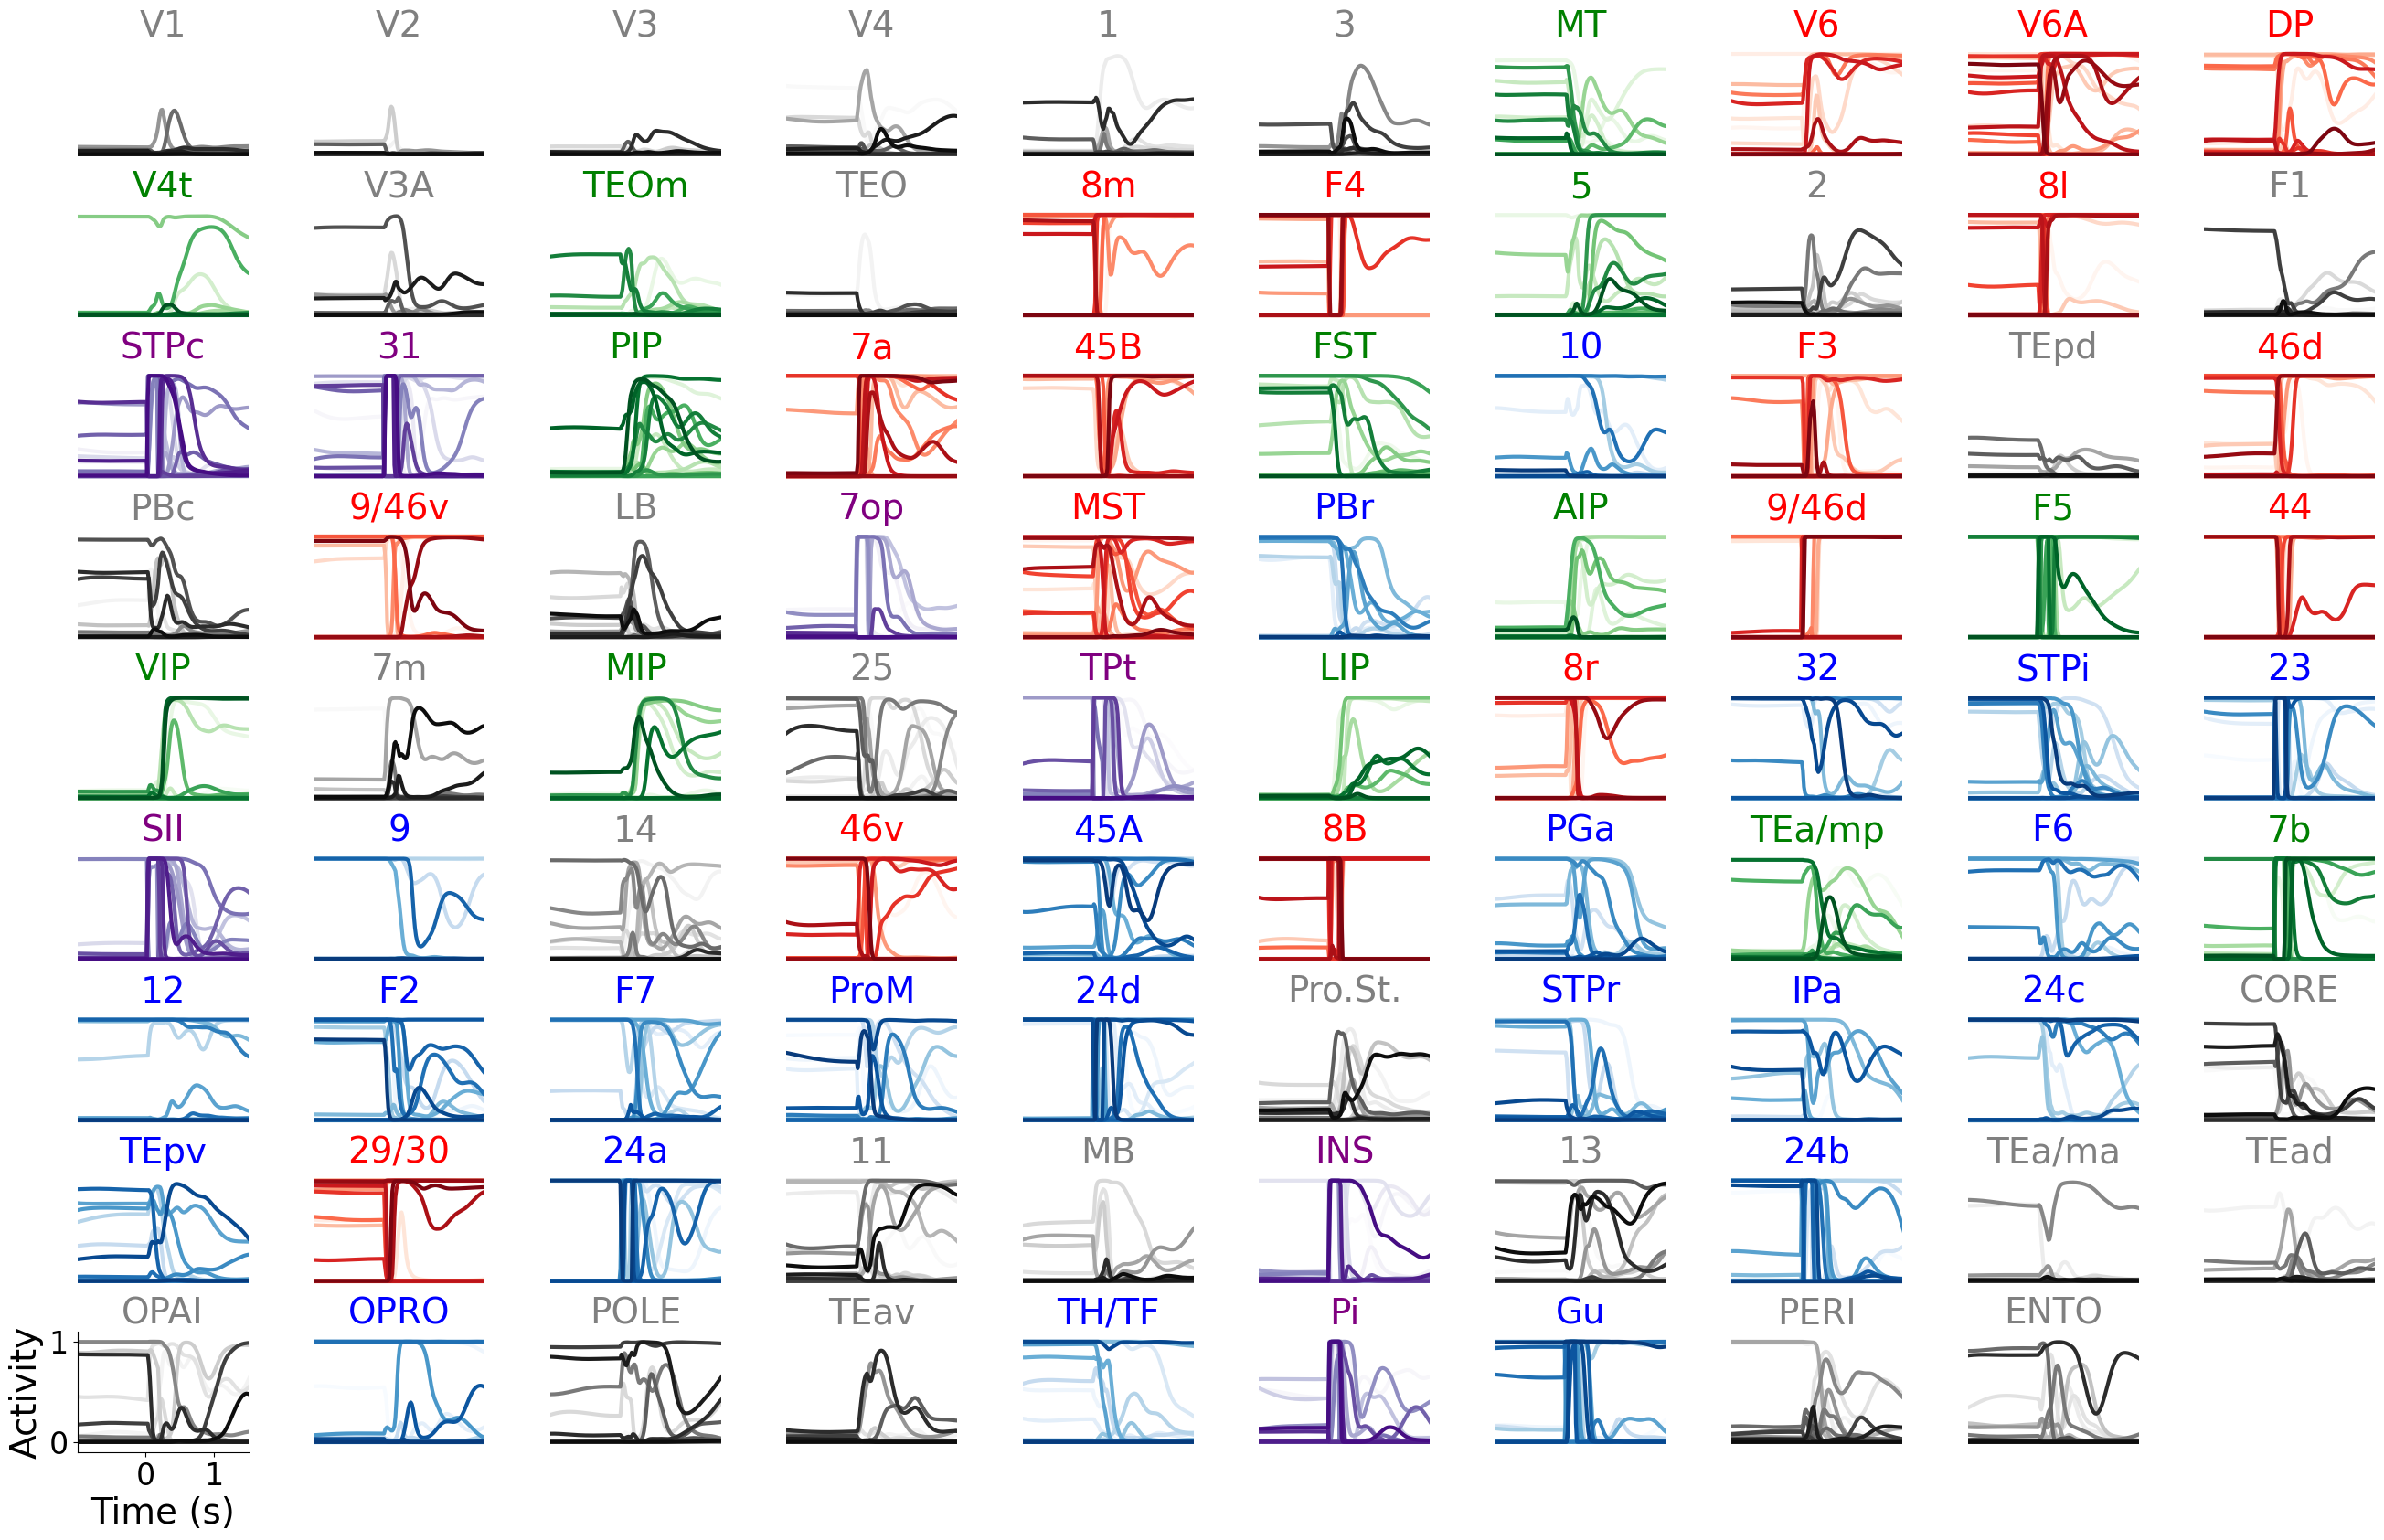

In [7]:
#results = pickle.load(open('data/gradient_chaos/sim_0.011.p', 'rb'))
time = results['time']
r_ctx = results['rates_ctx']
name_grad = 'figures/S_attractors_rates.pdf'

lw_ov = 2
lw_fr = 3


ov_color = 'blue'
m_fr_color = 'orange'
s_ticks = 24

fs=28
N_block = modelparams['N_block'] # resolution saved nurons 
N_recorded = modelparams['N_recorded'] # resolution saved nurons 
N_neu =int( N_block/int(N_block/N_recorded)) #number recorded neurons
colors = plt.cm.hsv(np.linspace(0,1, N_neu))
names_ctx, inds_full = names_inds_ctx()
dt = modelparams['dt']
t_stop = modelparams['period']
t_end = t_stop


colors_greens = plt.cm.Greens(np.linspace(0,1, N_neu))
colors_blues = plt.cm.Blues(np.linspace(0,1, N_neu))
colors_reds = plt.cm.Reds(np.linspace(0, 1 , N_neu))
colors_greys = plt.cm.Greys(np.linspace(0, 1 , N_neu))
colors_purples = plt.cm.Purples(np.linspace(0, 1 , N_neu))

# plotting altoghether 
fig, ax = plt.subplots(figsize=(26, 16),nrows=9, ncols=10)
fig.tight_layout()
l=0
n_row= 0
for row in ax:
    n_col=0
    for col in row:
        time = np.linspace(0, t_end , r_ctx.shape[0])
        if l<=88:
            ind_1 = l * N_neu
            ind_2 = (l+1) * N_neu
            #col.set_prop_cycle(cycler('color', colors))
            if l in FPN:
                color = 'red'
                for k in range(l * N_neu, (l+1)* N_neu, 10):
                    col.plot(time, r_ctx[:, k], lw=lw_fr, color = colors_reds[k - l* N_neu])
            elif l in DorsAtt:
                color = 'green'
                for k in range(l * N_neu, (l+1)* N_neu, 10):
                    col.plot(time, r_ctx[:, k], lw=lw_fr, color = colors_greens[k - l* N_neu])
            elif l in DMN:
                color = 'blue'
                for k in range(l * N_neu, (l+1)* N_neu, 10):
                    col.plot(time, r_ctx[:, k], lw=lw_fr, color = colors_blues[k - l* N_neu])
            elif l in salience:
                color = 'purple'
                for k in range(l * N_neu, (l+1)* N_neu, 10):
                    col.plot(time, r_ctx[:, k], lw=lw_fr, color = colors_purples[k - l* N_neu])
            else:
                color = 'grey'
                for k in range(l * N_neu, (l+1)* N_neu, 10):
                    col.plot(time, r_ctx[:, k], lw=lw_fr, color = colors_greys[k - l* N_neu])
            col.set_title(names_ctx[l],fontsize = fs, color = color)
        col.set_ylim([-.1,1.1])
        col.set_xlim([t_start-1., t_start+1.5])
        if n_col!=0:
            col.set_yticks([])
            col.set_xticks([])
            col.spines['right'].set_visible(False)
            col.spines['top'].set_visible(False)
            col.spines['left'].set_visible(False)
            col.spines['bottom'].set_visible(False)
        if n_row!=8:
            col.set_xticks([])
            col.set_yticks([])
            col.spines['right'].set_visible(False)
            col.spines['top'].set_visible(False)
            col.spines['left'].set_visible(False)
            col.spines['bottom'].set_visible(False)
        if n_col==0 and n_row==8:
            col.set_ylabel('Activity', fontsize =fs)
            col.set_yticks([0, 1])
            col.set_yticklabels([0, 1], fontsize = s_ticks)
            col.set_xlabel('Time (s)', fontsize = fs)
            col.set_xticks([t_start,  t_start+1.])
            col.set_xticklabels([0, 1], fontsize = s_ticks)
            col.spines['right'].set_visible(False)
            col.spines['top'].set_visible(False)

        l+=1
        n_col+=1
    n_row+=1
#plt.savefig(name_grad, bbox_inches='tight')

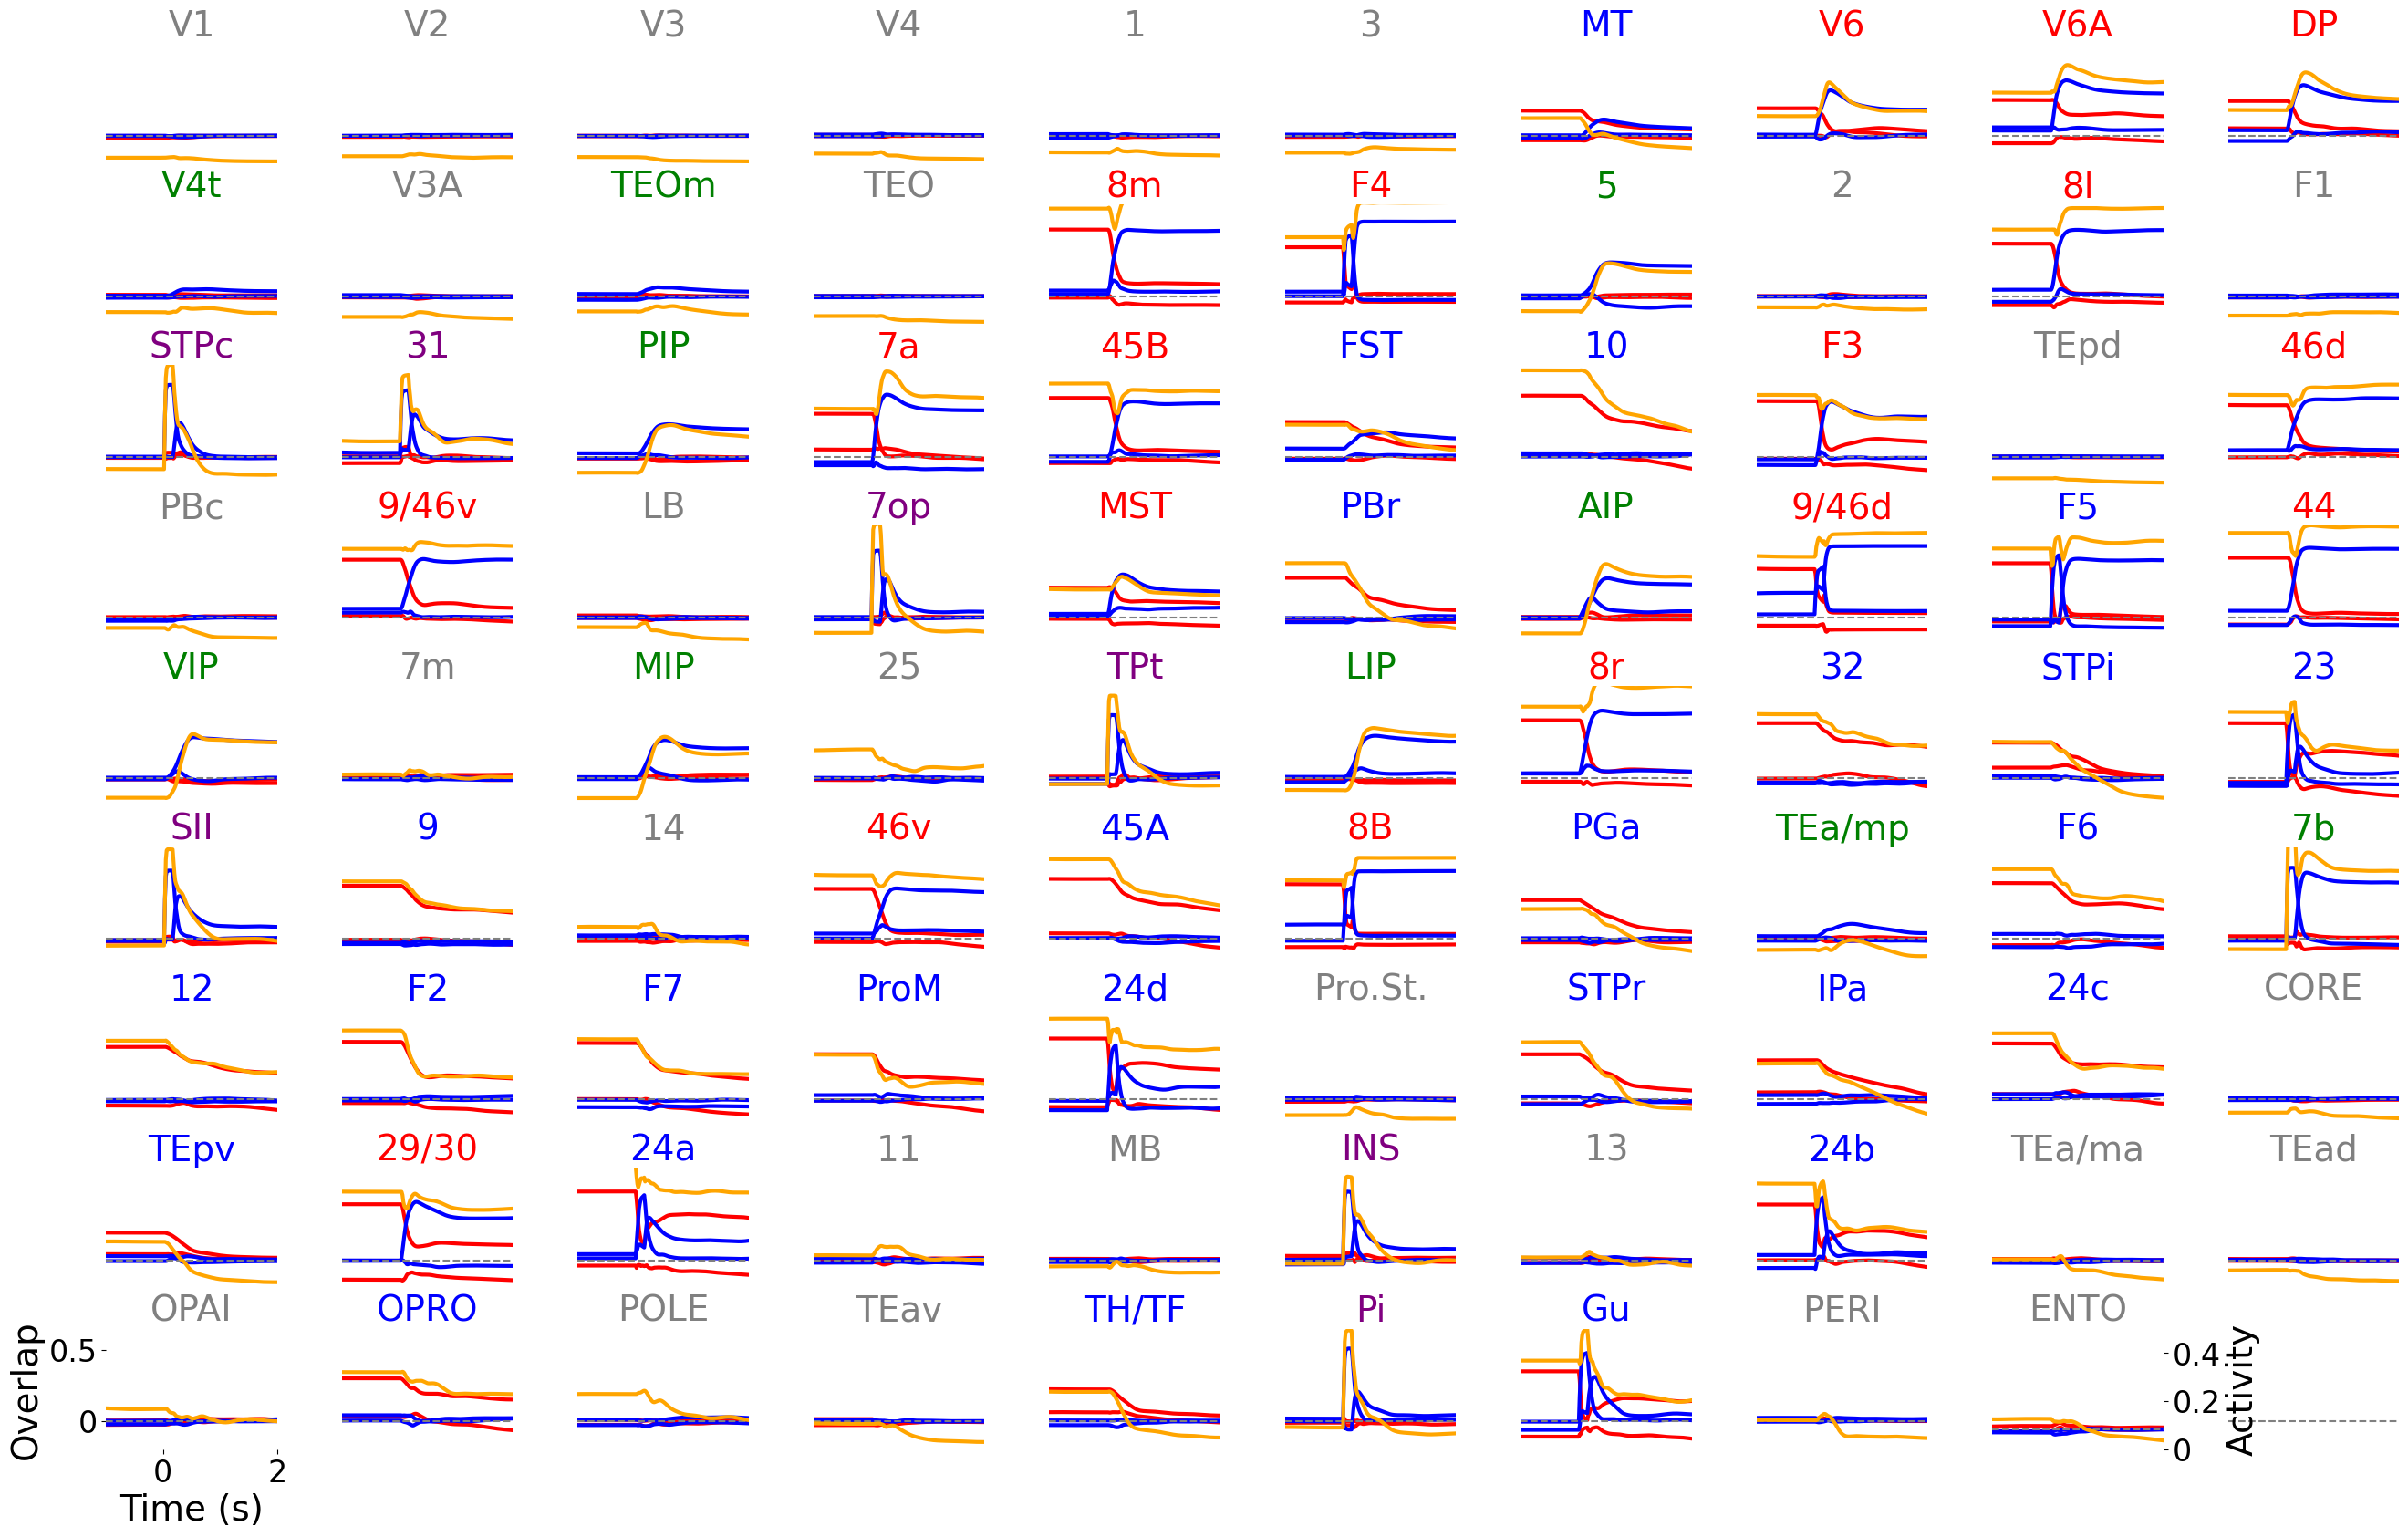

In [9]:
modelparams = model_parameters()

#results = pickle.load(open('data/gradient_chaos/sim_0.011.p', 'rb'))
time = results['time']
r_ctx = results['rates_ctx']
overlaps = results['overlaps_sym']
#overlaps_choice = results['overlaps_choice']
overlaps_rand = results['overlaps_random']

name_grad = 'figures/S_attractors_overlaps.pdf'

lw_ov = 3
lw_fr = 3

colors_overlaps = plt.cm.Dark2(np.linspace(0,1, 8))
ov_color = 'blue'
m_fr_color = 'orange'
s_ticks = 24

fs=28

N_block = modelparams['N_block']
p = overlaps.shape[2]
colors = plt.cm.hsv(np.linspace(0,1,N_block))
names_ctx, inds_full = names_inds_ctx()
dt = modelparams['dt']
t_end = overlaps.shape[0] * dt
t_stop = t_end
time = np.linspace(0, t_end , overlaps.shape[0])
colors = ['b', 'r']
fig, ax = plt.subplots(figsize=(26, 16),nrows=9, ncols=10)
fig.tight_layout()
l=0
n_row= 0
for row in ax:
    n_col=0
    for col in row:
        if l<89:
            #for s in range(p):
            if l in FPN:
                color = 'red'
            elif l in DMN:
                color = 'blue'
            elif l in DorsAtt:
                color = 'green'
            elif l in salience:
                color = 'purple'
            else:
                color = 'grey'
            
            col.plot(time, overlaps[:, l, 0, :], lw =lw_ov, color = 'r')
            #col.plot(time, overlaps[:, l, 0, 0], lw =lw_ov, color = 'r', ls = '--')
            col.plot(time, overlaps[:, l, 1, :], lw =lw_ov, color = 'b')
            #col.plot(time, overlaps[:, l, 1, 1], lw =lw_ov, color = 'b', ls = '--')
            col.set_title(names_ctx[l],fontsize = fs, color = color)
            axij = col.twinx()
            r_mean = np.mean(r_ctx[:, l * N_neu: (l + 1)* N_neu], axis = 1)
            axij.plot(time,  r_mean, color = m_fr_color, lw= lw_ov)
            axij.set_ylim([0,.5])
        col.set_ylim([-.2,0.65])
        col.set_xlim([t_start-1., t_start+2.])
        col.axhline(y=0, xmin=0, xmax=400, ls = '--',color='gray')
        if n_col!=0:
            col.set_yticks([])
            col.set_xticks([])
            col.spines['right'].set_visible(False)
            col.spines['top'].set_visible(False)
            col.spines['left'].set_visible(False)
            col.spines['bottom'].set_visible(False)
        if n_row!=9:
            col.set_xticks([])
            col.set_yticks([])
            col.spines['right'].set_visible(False)
            col.spines['top'].set_visible(False)
            col.spines['left'].set_visible(False)
            col.spines['bottom'].set_visible(False)
            axij.set_xticks([])
            axij.set_yticks([])
            axij.spines['right'].set_visible(False)
            axij.spines['top'].set_visible(False)
            axij.spines['left'].set_visible(False)
            axij.spines['bottom'].set_visible(False)
        if n_col==0 and n_row==8:
            col.set_ylabel('Overlap', fontsize =fs)
            col.set_yticks([0, 0.5])
            col.set_yticklabels([0, 0.5], fontsize = s_ticks)
            col.set_xlabel('Time (s)', fontsize = fs)
            col.set_xticks([t_start,  t_start+2.])
            col.set_xticklabels([0, 2], fontsize = s_ticks)
            col.spines['right'].set_visible(False)
            col.spines['top'].set_visible(False)
        if n_col != 9:
            axij.spines['right'].set_visible(False)
            axij.spines['top'].set_visible(False)
            axij.spines['left'].set_visible(False)
            axij.spines['bottom'].set_visible(False)
            axij.set_yticks([])
        if n_col==8 and n_row==8:
            axij.set_yticks([0, 0.2, 0.4])
            axij.set_yticklabels([0, 0.2, 0.4], fontsize = s_ticks)
            axij.set_ylabel('Activity', fontsize =fs)
            col.plot(time, -20 * time -1, lw =lw_ov, color = 'blue')
            axij = col.twinx()
            axij.plot(time,  -20 * time - 1, color = m_fr_color, lw= lw_ov)
            col.set_ylim([-.1,0.5])
            axij.set_ylim([0,.5])
            axij.spines['top'].set_visible(False)
            axij.spines['left'].set_visible(False)
            axij.spines['bottom'].set_visible(False)
            col.spines['top'].set_visible(False)
            col.spines['left'].set_visible(False)
            col.spines['bottom'].set_visible(False)
            col.set_xticks([])
            col.set_yticks([])
            col.set_xlabel('', fontsize = fs)
 
            
        l+=1
        n_col+=1
    n_row+=1
#plt.savefig(str_ov, bbox_inches='tight')
#plt.close()
plt.savefig(name_grad, bbox_inches='tight')

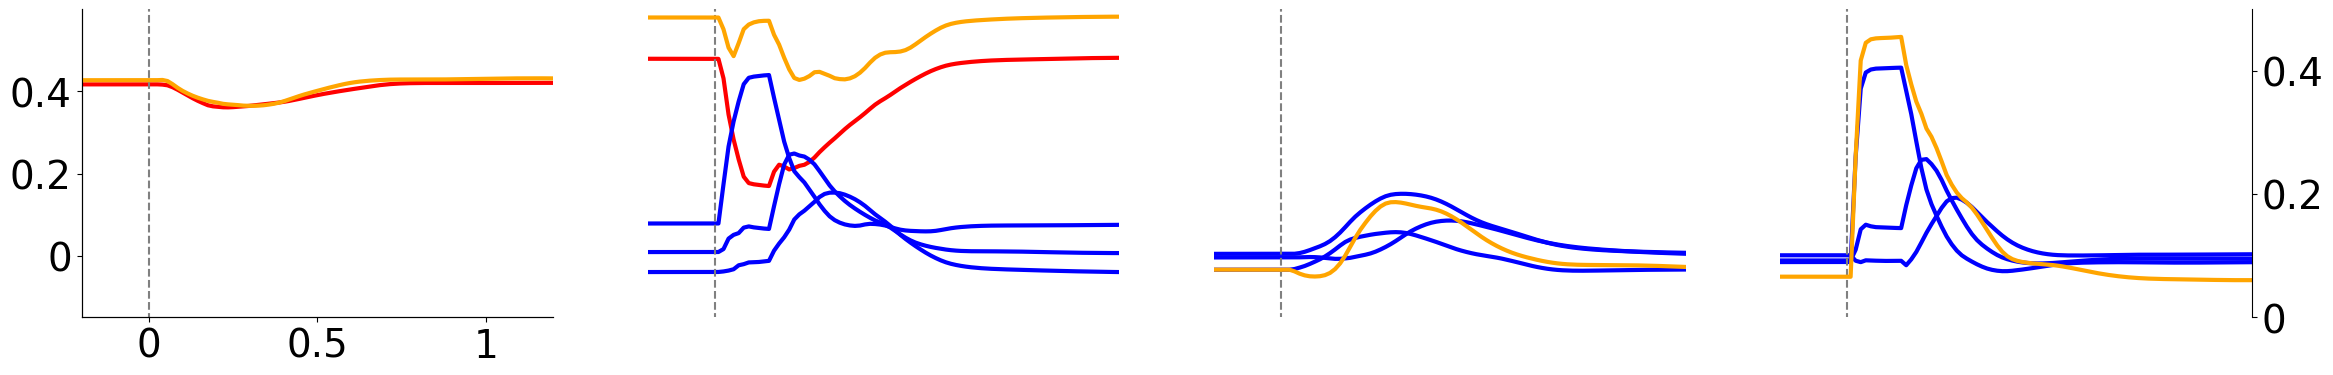

In [30]:
#hereee

time = results['time']
r_ctx = results['rates_ctx']
overlaps = results['overlaps_sym']


ov_color = 'blue'
m_fr_color = 'orange'
s_ticks = 28
lw_fr = 3 
lw_ov = 3

dt = modelparams['dt']
t_start = modelparams['t_start']
t_stop = t_start + 1.2
#ind_end = int(t_stop/dt)

t_end = t_stop
deltat = .2 

colors_blues = plt.cm.Blues(np.linspace(0,1, N_neu))
colors_reds = plt.cm.Reds(np.linspace(0, 1 , N_neu))
colors_greys = plt.cm.Greys(np.linspace(0, 1 , N_neu))
colors_greens = plt.cm.Greens(np.linspace(0, 1 , N_neu))

fig, ax = plt.subplots(figsize=(28, 4),nrows=1, ncols=4)

dN = 10
#frist column
ind1 = names_ctx.index('24c')
#for k in range(overlaps.shape[3]):
ax[0].plot(time, overlaps[:, ind1, 0, 0], color = 'r', lw= lw_ov)
#ax[0].plot(time, overlaps[:, ind1, 1, :], color = 'b', lw= lw_ov)
ax[0].set_ylim([-.15,0.6])
ax[0].set_xlim([t_end - 2, t_end])
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_xlim([t_start-deltat, t_end])
ax[0].set_xticks([t_start, t_start+0.5, t_start+1])
ax[0].set_xticklabels([ 0,  0.5, 1], fontsize = s_ticks)
ax[0].set_yticks([0, 0.2, 0.4])
ax[0].set_yticklabels([0, 0.2, 0.4], fontsize = s_ticks)
ax[0].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')

ax10 = ax[0].twinx()
r_mean1 = np.mean(r_ctx[:, ind1* N_neu: (ind1+1)* N_neu], axis = 1)
ax10.plot(time,  r_mean1, color = m_fr_color, lw= lw_ov)
ax10.set_ylim([0,0.5])
ax10.set_xlim([t_start-deltat, t_end])
ax10.set_xticks([t_start, t_start+0.5, t_start+1])
ax10.set_xticklabels([0,  0.5, 1], fontsize = s_ticks)
ax10.spines['right'].set_visible(False)
ax10.spines['top'].set_visible(False)
ax10.set_yticks([])



#second column

ind3 =  names_ctx.index('9/46d')#

ax[1].plot(time, overlaps[:, ind3, 0, 0], color = 'r', lw= lw_ov)
ax[1].plot(time, overlaps[:, ind3, 1, :], color = 'b', lw= lw_ov)
ax[1].set_ylim([-.15,0.6])
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].set_yticks([])
ax[1].set_xlim([t_start-deltat, t_end])
ax[1].set_xticks([])
#ax[1,2].set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax[1,2].set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
ax[1].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')

ax12 = ax[1].twinx()
r_mean = np.mean(r_ctx[:, ind3* N_neu: (ind3+1)* N_neu], axis = 1)
ax12.plot(time,  r_mean, color = m_fr_color, lw= lw_ov)
ax12.set_ylim([0,.5])
ax12.set_xlim([t_start-deltat, t_end])
ax12.set_xticks([])
#ax12.set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax12.set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
#ax12.spines['right'].set_visible(False)
ax12.spines['top'].set_visible(False)
ax12.spines['left'].set_visible(False)
ax12.spines['right'].set_visible(False)
ax12.spines['bottom'].set_visible(False)
ax12.set_yticks([])
#ax12.set_yticklabels([0, 0.2, 0.4], fontsize = s_ticks)

#6th column
ind6 = names_ctx.index('MIP')

#ax[2].plot(time, overlaps[:, ind6, 0, 0], color = 'r', lw= lw_ov)
ax[2].plot(time, overlaps[:, ind6, 1, :], color = 'b', lw= lw_ov)
ax[2].set_ylim([-.15,0.6])
ax[2].set_xlim([t_end - 2, t_end])
ax[2].spines['right'].set_visible(False)
ax[2].spines['top'].set_visible(False)
ax[2].spines['left'].set_visible(False)
ax[2].spines['bottom'].set_visible(False)
ax[2].set_yticks([])
ax[2].set_xlim([t_start-deltat, t_end])
ax[2].set_xticks([])
#ax[1,5].set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax[1,5].set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
ax[2].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
#ax[1,5].axhline(y=0, xmin=0, xmax=400, ls = '--',color='gray')

ax15 = ax[2].twinx()
r_mean = np.mean(r_ctx[:, ind6 * N_neu: (ind6 + 1)* N_neu], axis = 1)
ax15.plot(time,  r_mean, color = m_fr_color, lw= lw_ov)
ax15.set_ylim([0,.5])
ax15.set_xlim([t_start-deltat, t_end])
ax15.set_xticks([])
#ax15.set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax15.set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
#ax12.spines['right'].set_visible(False)
ax15.spines['top'].set_visible(False)
ax15.spines['left'].set_visible(False)
ax15.spines['right'].set_visible(False)
ax15.spines['bottom'].set_visible(False)
ax15.set_yticks([])


#6th column
ind6 = names_ctx.index('INS')

#ax[3].plot(time, overlaps[:, ind6, 0, 0], color = 'r', lw= lw_ov)
ax[3].plot(time, overlaps[:, ind6, 1, :], color = 'b', lw= lw_ov)
ax[3].set_ylim([-.15,0.6])
ax[3].set_xlim([t_end - 2, t_end])
ax[3].spines['right'].set_visible(False)
ax[3].spines['top'].set_visible(False)
ax[3].spines['left'].set_visible(False)
ax[3].spines['bottom'].set_visible(False)
ax[3].set_yticks([])
ax[3].set_xlim([t_start-deltat, t_end])
ax[3].set_xticks([])
#ax[1,5].set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax[1,5].set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
ax[3].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
#ax[1,5].axhline(y=0, xmin=0, xmax=400, ls = '--',color='gray')

ax15 = ax[3].twinx()
r_mean = np.mean(r_ctx[:, ind6 * N_neu: (ind6 + 1)* N_neu], axis = 1)
ax15.plot(time,  r_mean, color = m_fr_color, lw= lw_ov)
ax15.set_ylim([0,.5])
ax15.set_xlim([t_start-deltat, t_end])
ax15.set_xticks([])
#ax15.set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax15.set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
#ax12.spines['right'].set_visible(False)
ax15.spines['top'].set_visible(False)
ax15.spines['left'].set_visible(False)
ax15.spines['bottom'].set_visible(False)
ax15.set_yticks([0, 0.2, 0.4])
ax15.set_yticklabels([0, 0.2, 0.4], fontsize = s_ticks)

plt.savefig('figures/panels/salience_fpn_dan_dmn.pdf', bbox_inches='tight')

In [26]:
#saving results for display at the surface
if True:
    #save as mat file
    overlaps = results['overlaps_sym'][:,:,0,0]
    overlaps_salient = results['overlaps_sym'][:,:,1,0]
    overlaps_dmn = results['overlaps_sym'][:,:,1,1]
    ovs = {'overlaps_fpn':overlaps,
            'overlaps_salience':overlaps_salient,
            'overlaps_dmn':overlaps_dmn}
    sio.savemat('results/overlaps_salience_fpn_dan_dmn.mat', ovs)
    r_ctx = results['rates_ctx']
    N_block = modelparams['N_block'] # resolution saved nurons 
    N_recorded = modelparams['N_recorded'] # resolution saved nurons 
    N_neu =int( N_block/int(N_block/N_recorded)) #number recorded neurons
    mean_rates = []
    for l in range(89):
        r_mean = np.mean(r_ctx[:, l * N_neu: (l + 1)* N_neu], axis = 1)
        mean_rates.append(r_mean)
    mean_rates = np.array(mean_rates)
    sio.savemat('results/mean_rate_salience_fpn_dan_dmn.mat', {'mean_rates':mean_rates})
